<a href="https://colab.research.google.com/github/cherypallysaisurya/Hyper_Spectral_Img_Classification/blob/main/HSI_TRIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Indian_pines_corrected.mat already exists.
✅ Indian_pines_gt.mat already exists.
✅ PaviaU.mat already exists.
✅ PaviaU_gt.mat already exists.
✅ Salinas_corrected.mat already exists.
✅ Salinas_gt.mat already exists.
✅ Loaded dataset: IndianPines
Data shape: (145, 145, 200)
GT shape: (145, 145)


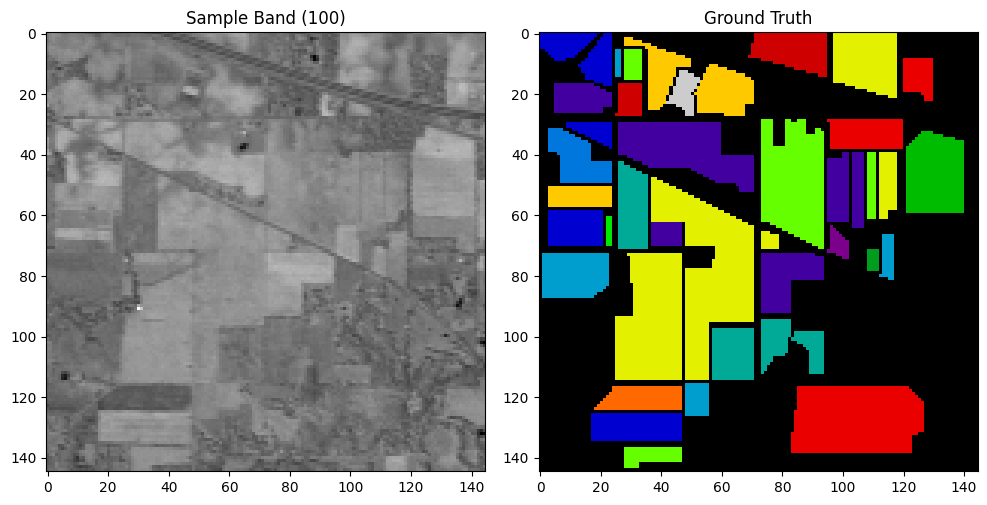

[1] Train Loss: 1.902 (▲49.29%) | Val Loss: 2.567 (▲24.90%)
[2] Train Loss: 1.522 (▲63.45%) | Val Loss: 2.388 (▲26.46%)
[3] Train Loss: 1.474 (▲64.23%) | Val Loss: 1.876 (▲34.08%)
[4] Train Loss: 1.279 (▲70.72%) | Val Loss: 1.660 (▲42.48%)
[5] Train Loss: 1.183 (▲76.57%) | Val Loss: 2.351 (▲35.06%)
[6] Train Loss: 1.154 (▲77.55%) | Val Loss: 2.328 (▲24.61%)
[7] Train Loss: 1.232 (▲77.40%) | Val Loss: 1.893 (▲45.31%)
[8] Train Loss: 1.032 (▲84.43%) | Val Loss: 2.458 (▲35.55%)
[9] Train Loss: 1.073 (▲84.72%) | Val Loss: 2.545 (▲28.71%)
[10] Train Loss: 1.102 (▲77.94%) | Val Loss: 2.411 (▲33.01%)
[11] Train Loss: 0.999 (▲82.24%) | Val Loss: 2.153 (▲42.38%)
[12] Train Loss: 0.988 (▲88.24%) | Val Loss: 2.217 (▲36.04%)
[13] Train Loss: 0.948 (▲90.43%) | Val Loss: 1.125 (▲58.89%)
[14] Train Loss: 0.841 (▲92.44%) | Val Loss: 1.111 (▲63.48%)
[15] Train Loss: 0.833 (▲92.39%) | Val Loss: 1.043 (▲63.87%)
[16] Train Loss: 0.924 (▲93.17%) | Val Loss: 1.736 (▲58.40%)
[17] Train Loss: 0.904 (▲91.61%) 

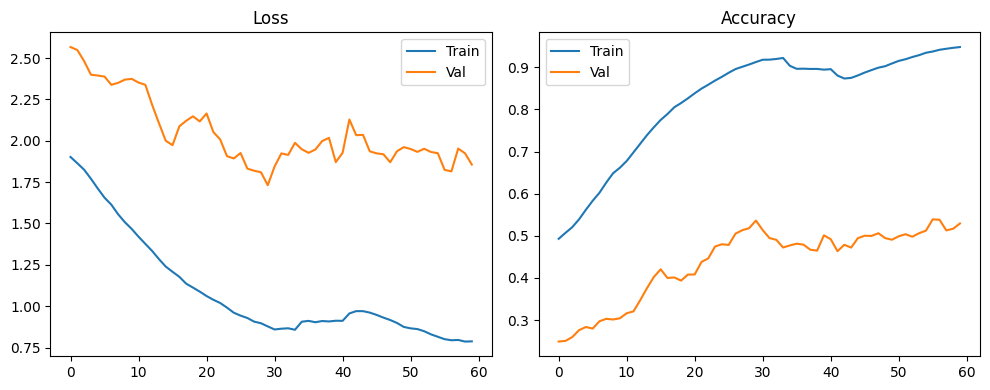


📊 Evaluation Metrics:
✅ Overall Accuracy (OA): 60.31%
✅ Average Accuracy (AA): 64.09%
✅ Kappa Coefficient: 0.5550


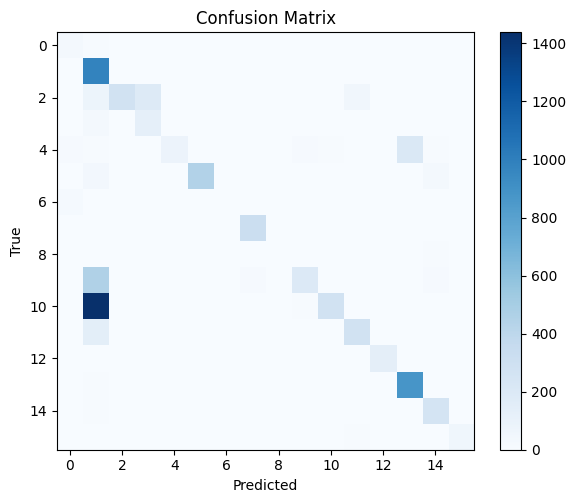

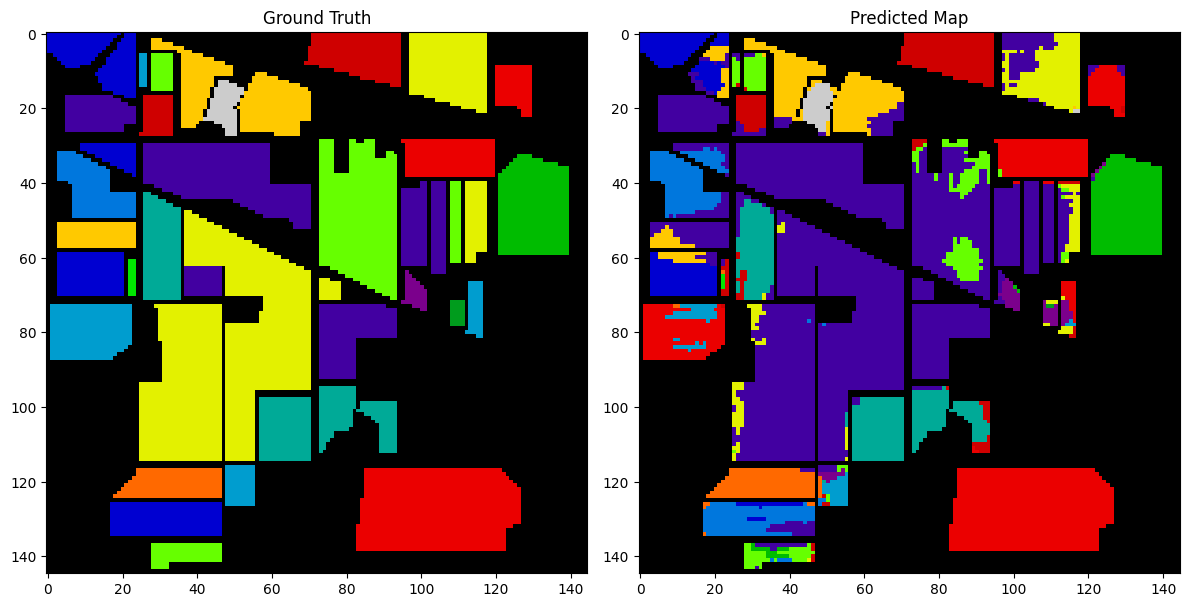

In [ ]:
# ==============================
# ✅ LIBRARIES & INSTALLS
# ==============================
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

# ==============================
# ✅ DATA DOWNLOAD
# ==============================
def download_dataset():
    urls = {
        "Indian_pines_corrected.mat": "https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat",
        "Indian_pines_gt.mat": "https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat",
        "PaviaU.mat": "https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat",
        "PaviaU_gt.mat": "https://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat",
        "Salinas_corrected.mat": "https://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat",
        "Salinas_gt.mat": "https://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat"
    }

    for filename, url in urls.items():
        if not os.path.exists(filename):
            print(f"⬇️ Downloading {filename}...")
            os.system(f"wget -q {url} -O {filename}")
        else:
            print(f"✅ {filename} already exists.")

download_dataset()

# Set dataset
dataset = "IndianPines"  # or "Salinas" or "PaviaU"

# ==============================
# ✅ LOAD DATASET
# ==============================
if dataset == "IndianPines":
    data = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
    gt = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
elif dataset == "Salinas":
    data = loadmat('Salinas_corrected.mat')['salinas_corrected']
    gt = loadmat('Salinas_gt.mat')['salinas_gt']
elif dataset == "PaviaU":
    data = loadmat('PaviaU.mat')['paviaU']
    gt = loadmat('PaviaU_gt.mat')['paviaU_gt']
else:
    raise ValueError("Unsupported dataset!")

print(f"✅ Loaded dataset: {dataset}")
print("Data shape:", data.shape)
print("GT shape:", gt.shape)

# ==============================
# ✅ VISUALIZE SAMPLE BAND
# ==============================
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(data[:, :, data.shape[2] // 2], cmap='gray')
plt.title(f"Sample Band ({data.shape[2] // 2})")
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='nipy_spectral')
plt.title("Ground Truth")
plt.tight_layout()
plt.show()

# ==============================
# ✅ DATA PREPROCESSING
# ==============================
def prepare_data(data, gt, patch_size=15, train_ratio=0.2, val_ratio=0.1):
    h, w, c = data.shape
    pad = patch_size // 2
    padded = np.pad(data, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
    idx = np.nonzero(gt)
    total = len(idx[0])
    indices = np.arange(total)
    np.random.shuffle(indices)

    n_train = int(train_ratio * total)
    n_val = int(val_ratio * total)

    def extract(idx_set):
        patches, labels = [], []
        for i in idx_set:
            r, c_ = idx[0][i], idx[1][i]
            patch = padded[r:r + patch_size, c_:c_ + patch_size, :]
            patch = np.transpose(patch, (2, 0, 1))
            patches.append(patch)
            labels.append(gt[r, c_] - 1)
        return np.array(patches), np.array(labels)

    train_idx = indices[:n_train]
    val_idx = indices[n_train:n_train + n_val]
    test_idx = indices[n_train + n_val:]

    return extract(train_idx) + extract(val_idx) + extract(test_idx)

train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(data, gt)

# ==============================
# ✅ MODEL DEFINITION
# ==============================
class VGGFeatureExtractor(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x.view(x.size(0), -1)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.depth = d_model // num_heads
        self.num_heads = num_heads
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, b):
        x = x.view(b, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)

    def forward(self, q, k, v):
        b = q.size(0)
        q = self.split_heads(self.wq(q), b)
        k = self.split_heads(self.wk(k), b)
        v = self.split_heads(self.wv(v), b)
        attn = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.depth, dtype=torch.float32))
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, v).permute(0, 2, 1, 3).contiguous()
        return self.dense(out.view(b, -1, self.num_heads * self.depth))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.ff = nn.Sequential(nn.Linear(d_model, d_ff), nn.GELU(), nn.Linear(d_ff, d_model))
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

class DenseTransformer(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, d_ff, seq_len):
        super().__init__()
        self.pos = nn.Parameter(torch.zeros(1, seq_len, d_model))
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.pos
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

class HybridModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.encoder = VGGFeatureExtractor(in_channels)
        self.trans = DenseTransformer(128, 4, 2, 256, 1)
        self.head = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, num_classes))

    def forward(self, x):
        feat = self.encoder(x).unsqueeze(1)
        out = self.trans(feat)
        return self.head(out[:, 0, :])

# ==============================
# ✅ LABEL SMOOTHING FUNCTION
# ==============================
def label_smoothing(preds, y, eps=0.1):
    n = preds.size(1)
    with torch.no_grad():
        y_onehot = torch.zeros_like(preds).scatter(1, y.unsqueeze(1), 1)
        y_onehot = y_onehot * (1 - eps) + eps / n
    return -(y_onehot * F.log_softmax(preds, dim=1)).sum(dim=1).mean()

# ==============================
# ✅ TRAINING LOOP
# ==============================
def smooth_curve(curve, factor=0.9):
    smoothed = []
    last = curve[0]
    for point in curve:
        smoothed_val = last * factor + (1 - factor) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

def train_model(model, train_x, train_y, val_x, val_y, epochs=60):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loader = DataLoader(TensorDataset(torch.Tensor(train_x), torch.LongTensor(train_y)), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.Tensor(val_x), torch.LongTensor(val_y)), batch_size=64)

    tr_loss, val_loss, tr_acc, val_acc = [], [], [], []

    for ep in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            preds = model(xb)
            loss = label_smoothing(preds, yb)
            loss.backward()
            opt.step()
            total_loss += loss.item()
            correct += (preds.argmax(1) == yb).sum().item()

        epoch_train_loss = total_loss / len(train_loader)
        epoch_train_acc = correct / len(train_loader.dataset)

        model.eval()
        val_loss_total, val_correct = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss_total += F.cross_entropy(preds, yb).item()
                val_correct += (preds.argmax(1) == yb).sum().item()

        epoch_val_loss = val_loss_total / len(val_loader)
        epoch_val_acc = val_correct / len(val_loader.dataset)

        tr_loss.append(epoch_train_loss)
        tr_acc.append(epoch_train_acc)
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

        print(f"[{ep+1}] Train Loss: {epoch_train_loss:.3f} (▲{epoch_train_acc*100:.2f}%) | "
              f"Val Loss: {epoch_val_loss:.3f} (▲{epoch_val_acc*100:.2f}%)")

    sm_tr_loss = smooth_curve(tr_loss)
    sm_val_loss = smooth_curve(val_loss)
    sm_tr_acc = smooth_curve(tr_acc)
    sm_val_acc = smooth_curve(val_acc)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(sm_tr_loss, label='Train')
    plt.plot(sm_val_loss, label='Val')
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(sm_tr_acc, label='Train')
    plt.plot(sm_val_acc, label='Val')
    plt.title("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==============================
# ✅ RUN TRAINING
# ==============================
in_channels = data.shape[2]
num_classes = len(np.unique(gt)) - 1
model = HybridModel(in_channels, num_classes)
train_model(model, train_x, train_y, val_x, val_y)

# ==============================
# ✅ EVALUATION
# ==============================
def evaluate_model(model, test_x, test_y):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    test_loader = DataLoader(TensorDataset(torch.Tensor(test_x), torch.LongTensor(test_y)), batch_size=64)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            all_preds.extend(preds.argmax(1).cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    oa = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    aa = np.mean(cm.diagonal() / cm.sum(axis=1))

    print("\n📊 Evaluation Metrics:")
    print(f"✅ Overall Accuracy (OA): {oa*100:.2f}%")
    print(f"✅ Average Accuracy (AA): {aa*100:.2f}%")
    print(f"✅ Kappa Coefficient: {kappa:.4f}")

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

evaluate_model(model, test_x, test_y)

# ==============================
# ✅ PREDICT FULL IMAGE
# ==============================
def predict_full_image(model, data, gt, patch_size=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    h, w, c = data.shape
    pad = patch_size // 2
    padded = np.pad(data, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')

    prediction_map = np.zeros((h, w), dtype=int)

    with torch.no_grad():
        for i in range(h):
            for j in range(w):
                if gt[i, j] == 0:
                    continue
                patch = padded[i:i + patch_size, j:j + patch_size, :]
                patch = np.transpose(patch, (2, 0, 1))
                patch_tensor = torch.Tensor(patch).unsqueeze(0).to(device)
                pred = model(patch_tensor).argmax(dim=1).cpu().item()
                prediction_map[i, j] = pred + 1

    return prediction_map

pred_map = predict_full_image(model, data, gt)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(gt, cmap='nipy_spectral')
plt.title("Ground Truth")

plt.subplot(1, 2, 2)
plt.imshow(pred_map, cmap='nipy_spectral')
plt.title("Predicted Map")

plt.tight_layout()
plt.show()


In [ ]:
# ==============================
# ✅ LIBRARIES & INSTALLS
# ==============================
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

# ==============================
# ✅ DATA DOWNLOAD
# ==============================
def download_dataset():
    urls = {
        "Indian_pines_corrected.mat": "https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat",
        "Indian_pines_gt.mat": "https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat",
        "PaviaU.mat": "https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat",
        "PaviaU_gt.mat": "https://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat",
        "Salinas_corrected.mat": "https://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat",
        "Salinas_gt.mat": "https://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat"
    }

    for filename, url in urls.items():
        if not os.path.exists(filename):
            print(f"⬇️ Downloading {filename}...")
            os.system(f"wget -q {url} -O {filename}")
        else:
            print(f"✅ {filename} already exists.")

download_dataset()

# Set dataset
dataset = "IndianPines"  # or "Salinas" or "PaviaU"

# ---------------------------
# Load Dataset
# ---------------------------
def load_dataset(name):
    paths = {
        "IndianPines": ("Indian_pines_corrected.mat", "indian_pines_corrected", "Indian_pines_gt.mat", "indian_pines_gt"),
        "Salinas": ("Salinas_corrected.mat", "salinas_corrected", "Salinas_gt.mat", "salinas_gt"),
        "PaviaU": ("PaviaU.mat", "paviaU", "PaviaU_gt.mat", "paviaU_gt"),
    }
    d_file, d_key, g_file, g_key = paths[name]
    data = loadmat(d_file)[d_key]
    gt = loadmat(g_file)[g_key]
    return data, gt

# ---------------------------
# Patch Extraction
# ---------------------------
def extract_patches(data, gt, patch_size=15, train_ratio=0.2, val_ratio=0.1):
    h, w, c = data.shape
    pad = patch_size // 2
    data = np.pad(data, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
    indices = np.argwhere(gt > 0)
    np.random.shuffle(indices)
    n_train = int(len(indices) * train_ratio)
    n_val = int(len(indices) * val_ratio)

    def create_set(idx):
        x, y = [], []
        for r, c in idx:
            patch = data[r:r+patch_size, c:c+patch_size, :]
            x.append(np.transpose(patch, (2, 0, 1)))
            y.append(gt[r, c] - 1)
        return np.array(x), np.array(y)

    train_x, train_y = create_set(indices[:n_train])
    val_x, val_y = create_set(indices[n_train:n_train+n_val])
    test_x, test_y = create_set(indices[n_train+n_val:])
    return train_x, train_y, val_x, val_y, test_x, test_y

# ---------------------------
# Label Smoothing
# ---------------------------
def label_smoothing(preds, y, eps=0.1):
    n_classes = preds.size(1)
    y_onehot = torch.zeros_like(preds).scatter(1, y.unsqueeze(1), 1)
    y_onehot = y_onehot * (1 - eps) + eps / n_classes
    return -(y_onehot * F.log_softmax(preds, dim=1)).sum(dim=1).mean()

# ---------------------------
# Model Components
# ---------------------------
class VGGExtractor(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.AdaptiveAvgPool2d((1, 1))
        )

    def forward(self, x):
        return self.features(x).view(x.size(0), -1)

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.out = nn.Linear(dim, dim)

    def forward(self, x):
        b, n, d = x.shape
        qkv = self.qkv(x).reshape(b, n, 3, self.heads, d // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv
        dots = (q @ k.transpose(-2, -1)) * self.scale
        attn = dots.softmax(dim=-1)
        out = (attn @ v).transpose(1, 2).reshape(b, n, d)
        return self.out(out)

class TransformerEncoder(nn.Module):
    def __init__(self, dim, heads, ff_dim, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(dim),
                MultiHeadSelfAttention(dim, heads),
                nn.LayerNorm(dim),
                nn.Sequential(nn.Linear(dim, ff_dim), nn.GELU(), nn.Linear(ff_dim, dim))
            ) for _ in range(layers)
        ])

    def forward(self, x):
        for norm1, attn, norm2, ff in self.layers:
            x = x + attn(norm1(x))
            x = x + ff(norm2(x))
        return x

class HSIModel(nn.Module):
    def __init__(self, in_ch, n_classes):
        super().__init__()
        self.cnn = VGGExtractor(in_ch)
        self.cls_token = nn.Parameter(torch.randn(1, 1, 128))
        self.pos_embed = nn.Parameter(torch.randn(1, 2, 128))
        self.transformer = TransformerEncoder(128, heads=4, ff_dim=256, layers=4)
        self.head = nn.Sequential(nn.LayerNorm(128), nn.Linear(128, n_classes))

    def forward(self, x):
        feat = self.cnn(x).unsqueeze(1)
        cls = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls, feat), dim=1) + self.pos_embed
        x = self.transformer(x)
        return self.head(x[:, 0])

# ---------------------------
# Training
# ---------------------------
def train(model, train_x, train_y, val_x, val_y, epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_loader = DataLoader(TensorDataset(torch.tensor(train_x).float(), torch.tensor(train_y).long()), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(val_x).float(), torch.tensor(val_y).long()), batch_size=64)

    for ep in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            pred = model(xb)
            loss = label_smoothing(pred, yb)
            loss.backward()
            opt.step()

        model.eval()
        val_correct = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_correct += (pred.argmax(1) == yb).sum().item()
        print(f"Epoch {ep+1}: Validation Accuracy = {val_correct / len(val_loader.dataset) * 100:.2f}%")

# ---------------------------
# Evaluation
# ---------------------------
def evaluate(model, test_x, test_y):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()
    preds, labels = [], []
    loader = DataLoader(TensorDataset(torch.tensor(test_x).float(), torch.tensor(test_y).long()), batch_size=64)
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pred = model(xb).argmax(1).cpu().numpy()
            preds.extend(pred)
            labels.extend(yb.numpy())

    cm = confusion_matrix(labels, preds)
    oa = accuracy_score(labels, preds)
    aa = np.mean(cm.diagonal() / cm.sum(axis=1))
    kappa = cohen_kappa_score(labels, preds)
    print(f"OA: {oa*100:.2f}%, AA: {aa*100:.2f}%, Kappa: {kappa:.4f}")
    return oa, aa, kappa, cm

# ---------------------------
# Run Pipeline
# ---------------------------
dataset = "IndianPines"
data, gt = load_dataset(dataset)
train_x, train_y, val_x, val_y, test_x, test_y = extract_patches(data, gt)
model = HSIModel(in_ch=data.shape[2], n_classes=np.max(gt))
train(model, train_x, train_y, val_x, val_y)
evaluate(model, test_x, test_y)


⬇️ Downloading Indian_pines_corrected.mat...
⬇️ Downloading Indian_pines_gt.mat...
⬇️ Downloading PaviaU.mat...
⬇️ Downloading PaviaU_gt.mat...
⬇️ Downloading Salinas_corrected.mat...
⬇️ Downloading Salinas_gt.mat...
Epoch 1: Validation Accuracy = 43.65%
Epoch 2: Validation Accuracy = 31.25%
Epoch 3: Validation Accuracy = 31.93%
Epoch 4: Validation Accuracy = 30.96%
Epoch 5: Validation Accuracy = 50.10%
Epoch 6: Validation Accuracy = 41.50%
Epoch 7: Validation Accuracy = 13.96%
Epoch 8: Validation Accuracy = 34.08%
Epoch 9: Validation Accuracy = 49.12%
Epoch 10: Validation Accuracy = 38.38%
Epoch 11: Validation Accuracy = 41.31%
Epoch 12: Validation Accuracy = 32.03%
Epoch 13: Validation Accuracy = 29.88%
Epoch 14: Validation Accuracy = 37.70%
Epoch 15: Validation Accuracy = 37.11%
Epoch 16: Validation Accuracy = 63.87%
Epoch 17: Validation Accuracy = 45.02%
Epoch 18: Validation Accuracy = 25.68%
Epoch 19: Validation Accuracy = 28.42%
Epoch 20: Validation Accuracy = 41.80%
Epoch 21: Va

(0.8285953177257525,
 np.float64(0.7746042451969546),
 np.float64(0.8008684380259956),
 array([[  27,    0,    0,    3,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [   0,  592,   55,    4,    0,    0,    0,    0,    0,    0,  333,
            0,    0,    0,    0,    0],
        [   0,    0,  547,    0,    0,    0,    0,    0,    0,    0,   27,
            0,    4,    0,    0,    0],
        [   0,    0,    2,  164,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [   0,    0,   12,    0,  262,    1,    0,    0,    0,    0,   62,
            0,   12,    0,    2,    0],
        [   0,    0,    0,    0,    0,  477,    0,    0,    0,    0,   44,
            0,    1,    0,    0,    0],
        [   0,    0,    0,    0,   10,    2,    5,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,  340,    0,    0,    0,
            0,    0,    0,    0, 